In [1]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.instance().ast_node_interactivity = "all"

In [ ]:
import math

import pytorch_lightning as pl
import torch
import torch.nn as nn

torch.set_float32_matmul_precision("medium")  # 推荐选项


# ==============================================================================
# 依赖的辅助模块和基类
# ==============================================================================


class FourierFeatures(nn.Module):
    """
    将标量t编码为傅里叶特征
    """

    def __init__(self, input_dim: int, mapping_size: int, scale: float = 10.0):
        super().__init__()
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        # 使用 register_buffer 是更规范的做法，因为它不是一个需要训练的参数
        self.register_buffer("B", torch.randn((input_dim, mapping_size)) * scale)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        if t.dim() == 1:
            t = t.unsqueeze(1)
        # 确保 t 是 float 类型
        t = t.float()
        # 核心操作: (batch_size, 1) @ (1, mapping_size) -> (batch_size, mapping_size)
        x_proj = 2 * math.pi * t @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class BaseModel(pl.LightningModule):
    """
    模型基类，包含通用的训练和优化逻辑
    """

    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.loss_fn = nn.MSELoss()

    def training_step(self, batch, batch_idx):
        x, t, y = batch
        y_hat = self.forward(x, t)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t, y = batch
        y_hat = self.forward(x, t)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


# ==============================================================================
# FourierMLPModel
# ==============================================================================


class FourierMLPModel(BaseModel):
    def __init__(
        self, x_dim: int, hidden_dim: int, num_layers: int, fourier_mapping_size: int, learning_rate: float = 1e-3
    ):
        super().__init__(learning_rate)
        self.save_hyperparameters()  # 保存所有超参数

        # 1. 创建t的傅里叶编码器
        self.fourier_encoder = FourierFeatures(input_dim=1, mapping_size=fourier_mapping_size)

        # 傅里叶特征的输出维度是 mapping_size * 2
        fourier_output_dim = fourier_mapping_size * 2

        # 2. 计算拼接后送入MLP的总维度
        total_input_dim = x_dim + fourier_output_dim

        # 3. 动态构建MLP层
        layers = []
        # 输入层
        layers.append(nn.Linear(total_input_dim, hidden_dim))
        layers.append(nn.ReLU())
        # 隐藏层
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        # 输出层
        layers.append(nn.Linear(hidden_dim, 1))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # a. 对 t 进行编码
        t_encoded = self.fourier_encoder(t)

        # b. 拼接 X 和编码后的 t
        combined_input = torch.cat([x, t_encoded], dim=-1)

        # c. 通过 MLP 进行预测
        y_hat = self.mlp(combined_input)
        return y_hat


# ==============================================================================
# DecompositionModel
# ==============================================================================


class FourierDecompositionModel(BaseModel):
    def __init__(
        self,
        x_dim: int,
        hidden_dim: int,
        interaction_dim: int,
        t_encoding_method: str = "fourier",  # 'fourier', 'fc', or 'none'
        fourier_mapping_size: int = 32,
        t_embedding_dim: int = 64,
        learning_rate: float = 1e-3,
    ):
        super().__init__(learning_rate)
        self.save_hyperparameters()  # 保存所有超参数

        # --- 动态定义 t 的编码器和输入维度 ---
        self.t_encoder = None
        t_input_dim = 1

        if t_encoding_method == "fourier":
            self.t_encoder = FourierFeatures(input_dim=1, mapping_size=fourier_mapping_size)
            t_input_dim = fourier_mapping_size * 2
            print(f"使用傅里叶特征编码t，编码后维度: {t_input_dim}")
        elif t_encoding_method == "fc":
            self.t_encoder = nn.Sequential(nn.Linear(1, t_embedding_dim), nn.ReLU())
            t_input_dim = t_embedding_dim
            print(f"使用可学习的FC层编码t，编码后维度: {t_input_dim}")
        elif t_encoding_method == "none":
            print("不使用任何编码，直接输入t。")
        else:
            raise ValueError("t_encoding_method 必须是 'fourier', 'fc', 或 'none'")

        # --- 定义模型的其余部分 ---
        # f_x(X) 部分
        self.f_x = nn.Sequential(nn.Linear(x_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))

        # f_t 和 g_t 部分，它们的输入维度由上面的逻辑决定
        self.f_t = nn.Sequential(nn.Linear(t_input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))
        self.g_x = nn.Sequential(nn.Linear(x_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, interaction_dim))
        self.g_t = nn.Sequential(nn.Linear(t_input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, interaction_dim))

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # 确保 t 的维度正确
        if t.dim() == 1:
            t = t.unsqueeze(1)

        # --- 根据所选方法对 t 进行编码 ---
        if self.t_encoder is not None:
            t_encoded = self.t_encoder(t)
        else:
            t_encoded = t  # 'none' 模式

        # --- 计算模型输出 ---
        fx_out = self.f_x(x)
        ft_out = self.f_t(t_encoded)
        gx_out = self.g_x(x)
        gt_out = self.g_t(t_encoded)

        interaction = (gx_out * gt_out).sum(dim=1, keepdim=True)

        y_hat = fx_out + ft_out + interaction
        return y_hat


In [6]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

# ==============================================================================
# 3. 数据和训练 (与之前相同)
# ==============================================================================


class ToyDataset(Dataset):
    def __init__(self, num_samples=1000, x_dim=10):
        self.num_samples = num_samples
        self.X = torch.randn(num_samples, x_dim)
        self.t = torch.rand(num_samples) * 10
        self.y = (
            torch.cos(self.X[:, 0])
            + 0.05 * (self.t**2)
            + self.X[:, 1] * torch.sin(self.t * math.pi / 5)
            + torch.randn(num_samples) * 0.05
        )
        self.y = self.y.unsqueeze(1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.t[idx], self.y[idx]

In [7]:
# --- 超参数 ---
X_DIM = 10
HIDDEN_DIM = 128
INTERACTION_DIM = 64
BATCH_SIZE = 128
EPOCHS = 15

# --- 数据加载 ---
dataset = ToyDataset(num_samples=10000, x_dim=X_DIM)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

# --- 通过一行代码切换模型配置，进行对比实验 ---

# 实验1：使用傅里叶特征
print("\n--- 实验1: 傅里叶特征编码 ---")
model_fourier = DecompositionModel(
    x_dim=X_DIM,
    hidden_dim=HIDDEN_DIM,
    interaction_dim=INTERACTION_DIM,
    t_encoding_method="fourier",
    fourier_mapping_size=32,
)

# 实验2：使用可学习的FC层
print("\n--- 实验2: FC层编码 ---")
model_fc = DecompositionModel(
    x_dim=X_DIM,
    hidden_dim=HIDDEN_DIM,
    interaction_dim=INTERACTION_DIM,
    t_encoding_method="fc",
    t_embedding_dim=64,  # 64 = 32 * 2, 为了与傅里叶特征的维度保持一致
)

# 实验3：不使用任何编码
print("\n--- 实验3: 无编码 (基线) ---")
model_none = DecompositionModel(
    x_dim=X_DIM, hidden_dim=HIDDEN_DIM, interaction_dim=INTERACTION_DIM, t_encoding_method="none"
)

# 选择一个模型进行训练 (例如，选择最高级的 'fourier' 版本)
model_to_train = model_fourier
print(f"\n将要训练的模型: {model_to_train.hparams.t_encoding_method} 编码")

# --- 训练器 ---
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator="auto", devices=1, log_every_n_steps=20, enable_checkpointing=False)

trainer.fit(model_to_train, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- 实验1: 傅里叶特征编码 ---
使用傅里叶特征编码t，编码后维度: 64

--- 实验2: FC层编码 ---
使用可学习的FC层编码t，编码后维度: 64

--- 实验3: 无编码 (基线) ---
不使用任何编码，直接输入t。

将要训练的模型: fourier 编码


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | loss_fn   | MSELoss         | 0      | train
1 | t_encoder | FourierFeatures | 0      | train
2 | f_x       | Sequential      | 1.5 K  | train
3 | f_t       | Sequential      | 8.4 K  | train
4 | g_x       | Sequential      | 9.7 K  | train
5 | g_t       | Sequential      | 16.6 K | train
------------------------------------------------------
36.2 K    Trainable params
0         Non-trainable params
36.2 K    Total params
0.145     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 63/63 [00:01<00:00, 60.75it/s, v_num=79, train_loss_step=0.0174, val_loss=0.0446, train_loss_epoch=0.0181] 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 63/63 [00:01<00:00, 60.59it/s, v_num=79, train_loss_step=0.0174, val_loss=0.0446, train_loss_epoch=0.0181]


In [ ]:
from typing import Optional

import lightning as pl
import numpy as np
from torch.utils.data import DataLoader


class DOSDataModule(pl.LightningDataModule):
    def __init__(
        self,
        desc: pd.DataFrame,
        dos_energy: pd.Series,
        dos: pd.Series,
        serial: Optional[pd.Series] = None,  # index->"train"/"val"/"test"
        batch_size: int = 32,
        random_seed: int = 42,
    ):
        super().__init__()
        self.desc = desc
        self.dos_energy = dos_energy
        self.dos = dos
        self.serial = serial
        self.batch_size = batch_size
        self.random_seed = random_seed

    def setup(self, stage=None):
        if self.serial is not None:
            train_idx = self.serial[self.serial == "train"].index
            val_idx = self.serial[self.serial == "val"].index
            test_idx = self.serial[self.serial == "test"].index
        else:
            # 自动划分
            all_idx = np.array(list(self.desc.index.intersection(self.dos.index).intersection(self.dos_energy.index)))
            rng = np.random.RandomState(self.random_seed)
            perm = rng.permutation(len(all_idx))
            n = len(all_idx)
            n_train = int(n * 0.7)
            n_val = int(n * 0.1)
            # n_test = n - n_train - n_val  # 未被使用，可删除
            train_idx = all_idx[perm[:n_train]]
            val_idx = all_idx[perm[n_train : n_train + n_val]]
            test_idx = all_idx[perm[n_train + n_val :]]
        self.train_dataset = DOSDataset(
            self.desc.loc[train_idx], self.dos_energy.loc[train_idx], self.dos.loc[train_idx]
        )
        self.val_dataset = DOSDataset(self.desc.loc[val_idx], self.dos_energy.loc[val_idx], self.dos.loc[val_idx])
        self.test_dataset = DOSDataset(self.desc.loc[test_idx], self.dos_energy.loc[test_idx], self.dos.loc[test_idx])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
import random

import matplotlib.pyplot as plt
import torch


def plot_prediction_pairs(samples, *, n=9, seed=42, prop="", title_prefix="Sample", show_true=True, show_pred=True):
    """
    输入 samples: List of (t, v_true) 或 (t, v_true, v_pred)
    自动判断有无 pred，进行单曲线或对比绘图
    只取每条曲线中间90%的数据进行绘制
    show_true: 是否绘制真实曲线
    show_pred: 是否绘制预测曲线
    额外输出本次抽中的indices
    """
    random.seed(seed)  # 固定随机种子以确保可重复性

    indices = random.sample(range(len(samples)), n)
    print("plot_prediction_pairs indices:", indices)  # 输出抽中的indices
    n_cols = int(np.sqrt(n))
    n_rows = int(np.ceil(n / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        entry = samples[idx]
        if len(entry) == 2:
            t, v_true = entry
            v_pred = None
        elif len(entry) == 3:
            t, v_true, v_pred = entry
        else:
            raise ValueError("Each sample must be (t, v_true) or (t, v_true, v_pred)")

        t = t.squeeze(-1).cpu().numpy()
        v_true = v_true.squeeze(-1).cpu().numpy()
        n_points = len(t)
        start = int(n_points * 0.05)
        end = int(n_points * 0.95)
        t_mid = t[start:end]
        v_true_mid = v_true[start:end]

        ax = axes[i]
        if show_true:
            ax.plot(t_mid, v_true_mid, label="True", linewidth=1.5)
        if show_pred and v_pred is not None:
            v_pred = v_pred.squeeze(-1).cpu().numpy()
            v_pred_mid = v_pred[start:end]
            ax.plot(t_mid, v_pred_mid, label="Pred", linewidth=1.5)
        ax.set_title(f"{title_prefix} #{idx}")
        ax.set_xlabel("Temperature (K)")
        ax.set_ylabel(prop)
        ax.legend()

    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
import joblib
import pandas as pd
from pymatgen.core import Composition

preprocessing_objects = joblib.load("/data/foundation_model/data/preprocessing_objects_20250529.pkl.z")
qc_ac_te_mp_dos_data = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_reformat_20250529.pd.parquet")
qc_ac_te_mp_dos_data = qc_ac_te_mp_dos_data.loc[~qc_ac_te_mp_dos_data.index.isin(preprocessing_objects["dropped_idx"])]
qc_ac_te_mp_dos_data.composition = qc_ac_te_mp_dos_data.composition.apply(
    lambda x: Composition({k: v for k, v in x.items() if v is not None and v > 0})
)
desc_trans = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_composition_desc_trans_20250529.pd.parquet")

In [7]:
_ = [
    "Thermal conductivity",  # 0
    "Electrical resistivity",  # 1
    "Power factor",  # 2
    "Seebeck coefficient",  # 3
    "ZT",  # 4
    "Magnetic susceptibility",  # 5
    "DOS density",  # 6
]

prop = _[2]

prop_value = qc_ac_te_mp_dos_data[prop].dropna()
prop_value_norm = qc_ac_te_mp_dos_data[f"{prop} (normalized)"].loc[prop_value.index]
prop_T = qc_ac_te_mp_dos_data[f"{prop} (T/K)"].loc[prop_value.index]
dos_energy = qc_ac_te_mp_dos_data["DOS energy"].loc[prop_value.index]
desc = desc_trans.loc[prop_value.index]
split = qc_ac_te_mp_dos_data["split"].loc[prop_value.index]

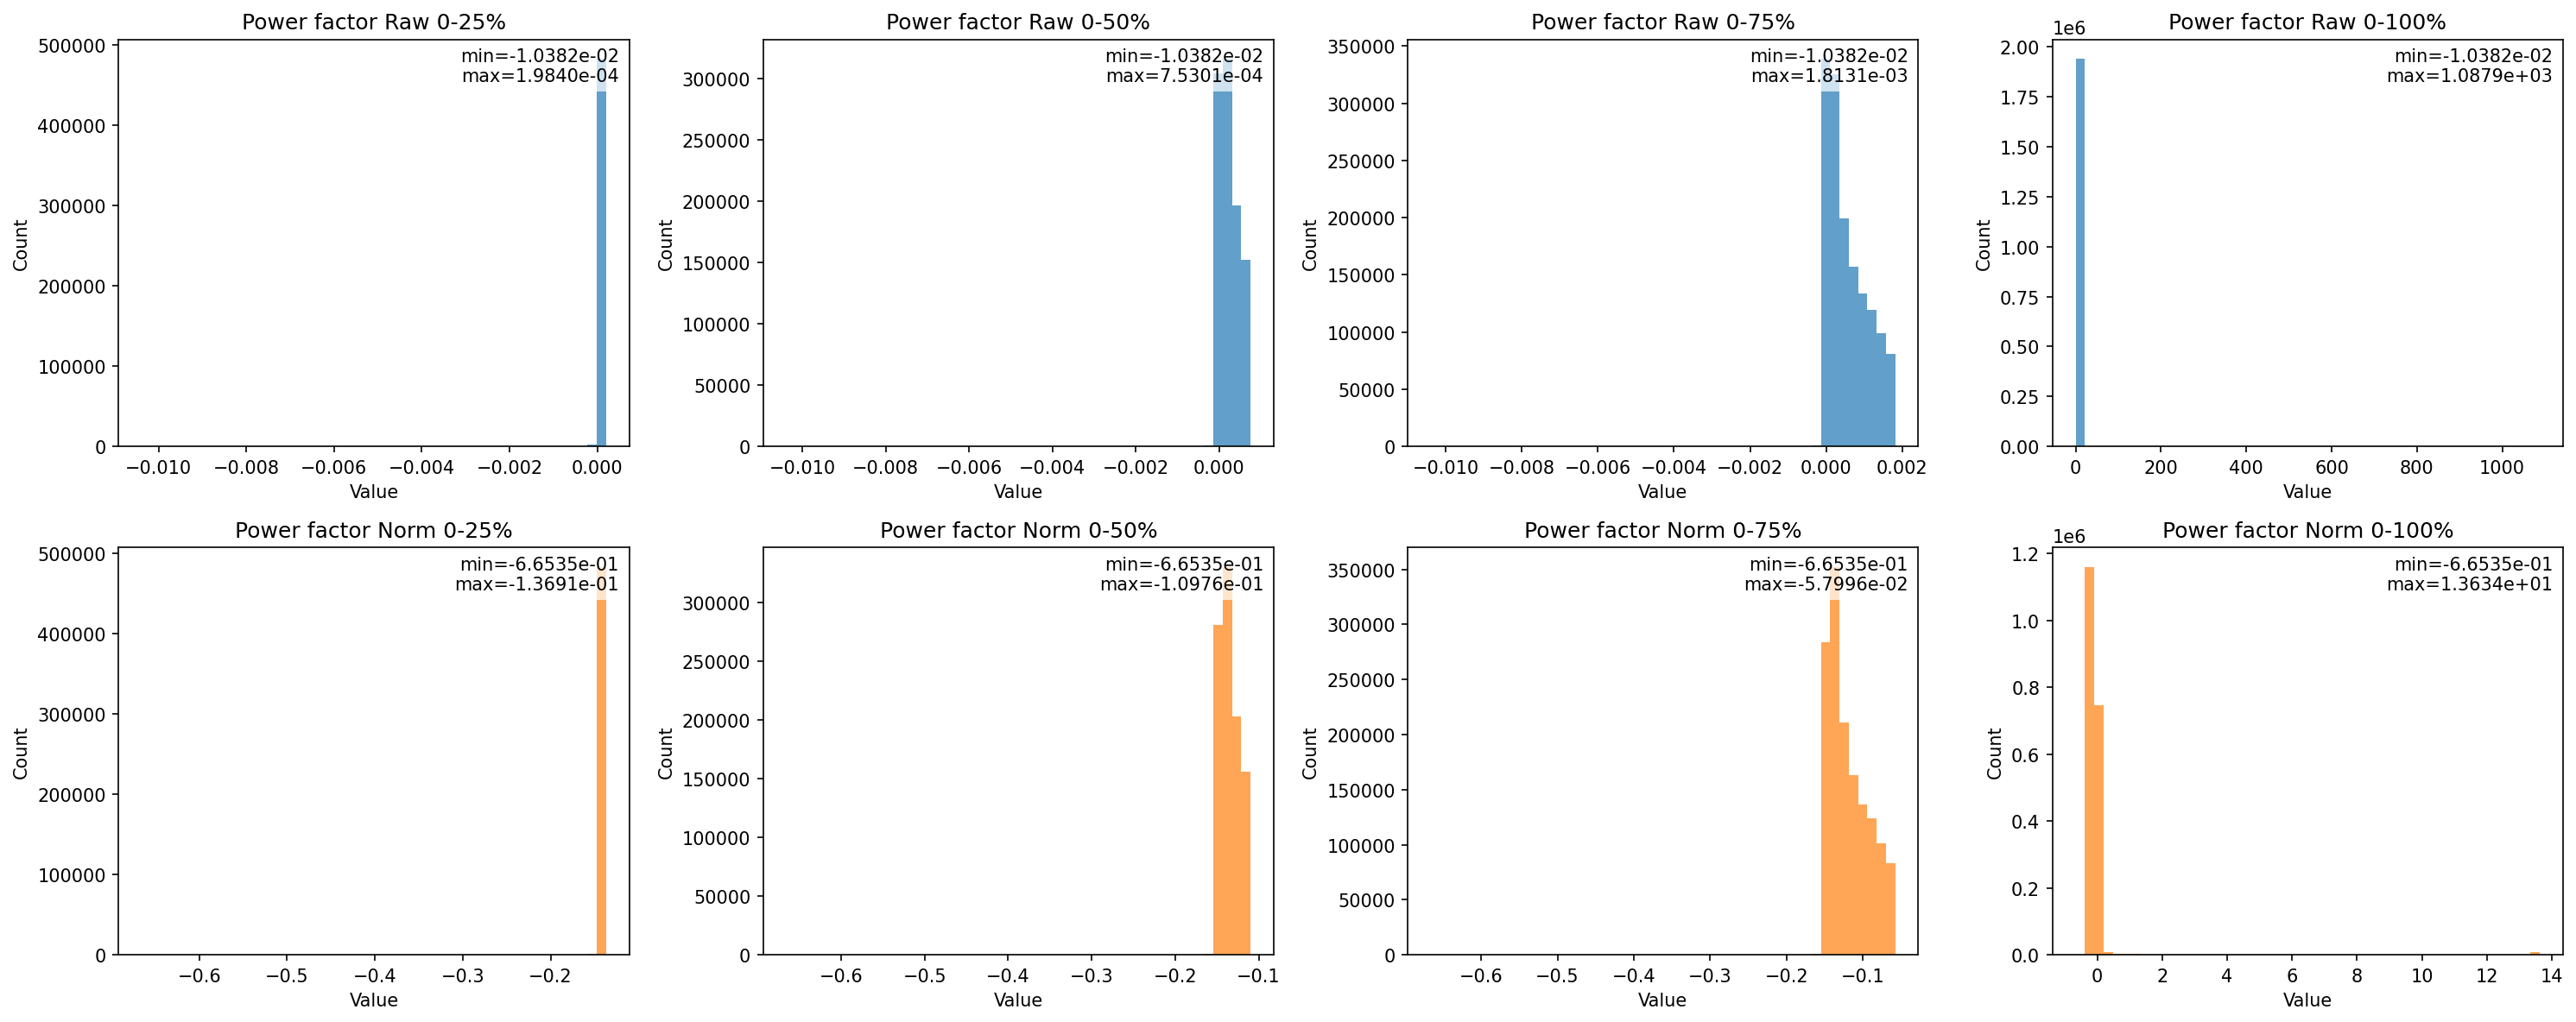

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), dpi=150)
percentiles = [0.25, 0.5, 0.75, 1.0]
titles = ["0-25%", "0-50%", "0-75%", "0-100%"]

for row, data_series in enumerate([prop_value, prop_value_norm]):
    a = np.concatenate([i for i in data_series])
    a_sorted = np.sort(a)
    n = len(a_sorted)
    for col, p in enumerate(percentiles):
        end = int(n * p)
        data_slice = a_sorted[:end]
        ax = axes[row, col]
        _ = ax.hist(data_slice, bins=50, color="C0" if row == 0 else "C1", alpha=0.7)
        min_val, max_val = data_slice.min(), data_slice.max()
        _ = ax.set_title(f"{prop} {'Raw' if row == 0 else 'Norm'} {titles[col]}")
        _ = ax.text(
            0.98,
            0.98,
            f"min={min_val:.4e}\nmax={max_val:.4e}",
            ha="right",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )
        _ = ax.set_xlabel("Value")
        _ = ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | SequenceHeadTCNFiLM | 2.1 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.428     Total estimated model params size (MB)


/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (71) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:  25%|██▌       | 18/71 [00:00<00:00, 69.70it/s, v_num=78, train/loss_step=1.54e+4]

Epoch 1: 100%|██████████| 71/71 [00:01<00:00, 69.25it/s, v_num=78, train/loss_step=295.0, val/loss=416.0, train/loss_epoch=595.0]   

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 71/71 [00:01<00:00, 65.85it/s, v_num=78, train/loss_step=295.0, val/loss=416.0, train/loss_epoch=595.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 168.09it/s]
plot_prediction_pairs indices: [149, 470, 465, 974, 789, 178, 722, 402, 749]


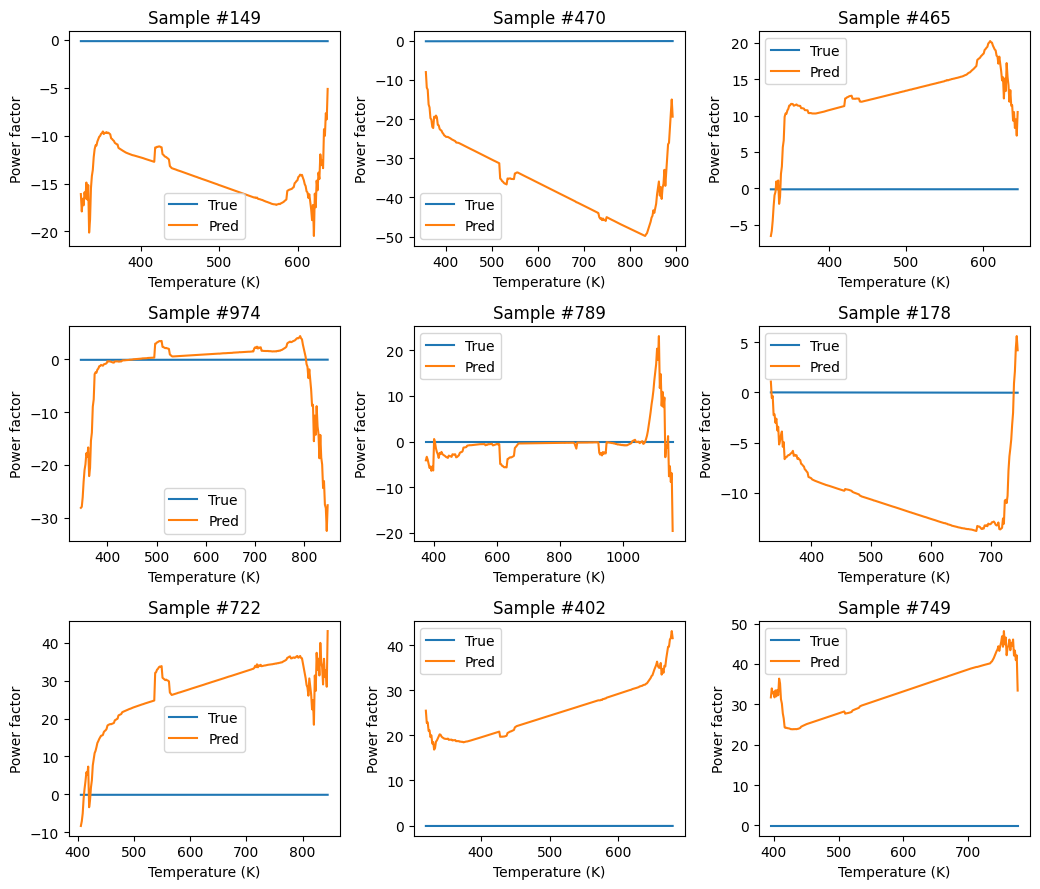

In [10]:
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping

# 1. 初始化数据模块
dm = DOSDataModule(
    desc=desc,
    dos_energy=prop_T,
    dos=prop_value_norm,
    serial=split,
    batch_size=64,
    random_seed=42,
)
dm.setup()

# 2. 初始化模型
model = LightningTCNFiLM(
    d_in=desc.shape[1],
    hidden=128,
    n_layers=4,
    kernel_size=30,
    lr=1e-3,
)

# 3. 初始化训练器
trainer = Trainer(
    max_epochs=2,
    accelerator="auto",
    callbacks=[EarlyStopping(monitor="val/loss", patience=5, mode="min")],
    log_every_n_steps=100,
)

# 4. 开始训练
trainer.fit(model, datamodule=dm)

# 5. predict
preds = trainer.predict(model, dataloaders=dm.test_dataloader())

# 6. 可视化预测结果
# flatten and pass to plot
samples = [sample for batch in preds for sample in zip(*batch)]
plot_prediction_pairs(samples, n=9, prop=prop, seed=100, show_pred=True)